### imports

In [2]:
!pip install tensorflow
!pip install gensim
!pip install tf-keras

In [1238]:
import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sentence_transformers import SentenceTransformer
import json
import contractions
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import copy
import statistics

# maintIE inherent function clusters

#### analysing exceptions with inherent functions 

In [19]:
def analyse_inherent_function_exceptions(row, exception_type=None):

    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject":
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation
    if exception_type == "1":
        if physical_object_indices and inherent_function_index:
            print(row)
            for i in physical_object_indices:
                print(row["entities"][i])
            print()
    # EXCEPTION 2: if there is zero, or more than one physical object and no hasPart relation
    elif exception_type == "2":
        # count how many non substance physical objects there are
        ob = []
        for e in row["entities"]:
            if e["type"].split("/")[0] == "PhysicalObject" and (len(e["type"].split("/")) == 1 or (len(e["type"].split("/"))>1 and e["type"].split("/")[1]  != "Substance")):
                ob.append(e)

        if (len(inherent_function_index) == 0) and len(ob)!=1 and not isA_relations_indices:
            print(row)
            print("Number of non-substance Physical Objects:", len(ob))
            if ob:
                print(ob)
            print()
    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if exception_type == "3":
        if (len(inherent_function_index) > 1):
            print(row)
    # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    if exception_type == "4":
        for i in isA_relations_indices:
            if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
                print(row)
    return

f = open("../data/gold_release.json", "r")
# returns JSON object as a dictionary
data = json.load(f)
f.close()

except_type = input("Enter exception type: ")
MWO_by_function = {}

for datum in data:
    types = [e["type"].split("/")[0] for e in datum["entities"]]
    if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
        analyse_inherent_function_exceptions(datum, exception_type=except_type)

{'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]}
Number of non-substance Physical Objects: 0

{'text': '<id> auto-greaser leaking oil', 'tokens': ['<id>', 'auto-greaser', 'leaking', 'oil'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/GeneratingObject/LiquidFlowGeneratingObject'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}, {'start': 3, 'end': 4, 'type': 'PhysicalObject/ProtectingObject/WearProtectingObject'}], 'relations': [{'head': 1, 'tail': 2, 'type': 'hasParticipant/hasPatient'}, {'head': 1, 'tail': 0, 'type': 'hasParticipant/hasAgent'}]}
Number of non-substance Physical Objects: 2
[{'start': 1, 'end': 2, 'type': 'PhysicalObject/GeneratingObject/LiquidFlowGeneratingObject'}, {'start': 3, 'end': 4, 'type': 'PhysicalObject/Pro

## Prepare Data

In [854]:
def extract_function_from_entity_index(row, index, equipment_dict=None):
    if equipment_dict:
        start = row["entities"][index]["start"]
        end = row["entities"][index]["end"]
        equipment = " ".join([row["tokens"][i] for i in range(start, end)])
        if equipment not in equipment_dict.keys():
            return None
        return equipment_dict[equipment][:-6].lower()
    types = row["entities"][index]["type"].split("/")
    if len(types) > 1:
        return types[1][:-6].lower()
    else:
        return None
    
def get_inherent_function(row, equipment_dict=None):

    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject" and (equipment_dict or len(row["entities"][i]["type"].split("/")) == 1 or (row["entities"][i]["type"].split("/")[1]  != "Substance")):
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation, and there is a hasPart relation
    if physical_object_indices and inherent_function_index:
        # in general, ignore additional physical objects 
        if len(inherent_function_index) ==1:
            isA_tails = [i[1] for i in isA_relations_indices]
            # if there is a more specific (head) object in an isA relation
            if inherent_function_index[0] in isA_tails:
                isA_head_index = isA_relations_indices[isA_tails.index(inherent_function_index[0])][0]
                func = extract_function_from_entity_index(row, isA_head_index, equipment_dict)
                return func
            else:
                func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
                return func


    # EXCEPTION 2: if there is zero or more than one physical object and no hasPart relations
    if (len(inherent_function_index) == 0) and len(physical_object_indices)!=1 and not isA_relations_indices:
        # if there are no physical objects, remove the row
        if len(physical_object_indices) == 0:
            print("remove:",row, "\n")
            return None
        physical_object_not_substance = []
        for i in physical_object_indices:
            start = row["entities"][i]["start"]
            end = row["entities"][i]["end"]
            # if the physical object is not a substance
            if end == len(row["tokens"]) and " ".join(row["tokens"][start:]) != "oil":
                physical_object_not_substance.append(i)
            elif " ".join(row["tokens"][start:end]) != "oil":
                physical_object_not_substance.append(i)

        # if there is only one non-substance physical object, extract its function
        if len(physical_object_not_substance) == 1:
            func = extract_function_from_entity_index(row, physical_object_not_substance[0], equipment_dict)
            return func
        else:
            # !!! CHECK !!!
            # print(row)
            # print("Manually assign inherent function.")
            # print()
            # return "CHECK"
            func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
            return func
            
                

    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if (len(inherent_function_index) > 1):
        # manually assign inherent function
        if row["text"] == "replace unserviceable transmission screen and magnet":
            return "transforming"
        elif row["text"] == "pump drive box coupling and shaft unserviceable":
            return "driving"
        else:
            return None
            # print(row)
            # raise Exception("Manually assign inherent function in Exception 3.")
    

    # get entities
    if len(inherent_function_index) == 1 and len(physical_object_indices) == 0:
        func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
        return func
    elif len(inherent_function_index) == 0 and len(physical_object_indices) == 1:
        func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
        return func
    elif all(i in [x for xs in isA_relations_indices for x in xs] for i in physical_object_indices):
        isA_heads = [i[0] for i in isA_relations_indices]
        isA_tails = [i[1] for i in isA_relations_indices]
        isA_specific_indices = []
        for i in isA_heads:
            if i not in isA_tails:
                isA_specific_indices.append(i)
        if len(isA_specific_indices) == 1:
            func = extract_function_from_entity_index(row, isA_specific_indices[0], equipment_dict)
            return func
        
        else:
            if row["text"] == "<id> park brake alarm fault":
                return "restricting"
            else:
                return None
                # print(row)
                # print("Manually assign inherent function.")
                # return "CHECK"
    elif len(inherent_function_index)>1:
        return None
        # print("SASDKDHAA")
        # return "CHECK"
    else:
        return None
        # print(row)
        # print("Manually assign inherent function.")
        # print()
        # return "CHECK"
    
    # for e in row["entities"]:
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             if entity_type[1][:-6].lower() not in functions:
    #                 functions.append(entity_type[1][:-6].lower())
    # functions = ",".join(sorted(functions))
    # return functions

    # # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    # if exception_type == 4:
    #     for i in isA_relations_indices:
    #         if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
    #             print(row)


def get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()


    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum)
            if not inherent_function:
                continue

            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
                

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            # add state, equipment, and inherent function to dictionary with key MWO
            mwo = " ".join(tokens)
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO

In [995]:
def create_equipment_dictionary():
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    
    # exception multiple types for the same equipment
    ignored_equipment = {"auto-lube":"ProtectingObject", "axle":"GuidingObject", "drag":"MatterProcessingObject", "universal joint":"GuidingObject", "adaptor":"InterfacingObject", "batteries":"StoringObject", "carousel":"StoringObject", "window":"RestrictingObject", "shaft":"GuidingObject", "input shaft":"GuidingObject"}
    equipment = ignored_equipment.copy()
    
    for datum in data:
        for e in datum["entities"]:
            entity_type = e["type"].split("/")
            if entity_type[0] == "PhysicalObject" and len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                start = int(e["start"])
                end = int(e["end"])
                equipment_text = " ".join([datum["tokens"][t] for t in range(start, end)])
                
                if equipment_text in ignored_equipment:
                    continue
                if equipment_text not in equipment:
                    equipment[equipment_text] = entity_type[1]
                # elif equipment[equipment_text] != entity_type[1]:
                #     del equipment[equipment_text]
                    # ignored_equipment.append(equipment_text)
                    
                    # print("ERROR: Equipment text has multiple types")
                    # print(equipment_text)
                    # print(equipment[equipment_text])
                    # print(entity_type[1])
                    # print()
    return equipment

def get_synthetic_dataset(filename, dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    import csv


    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        counter = 0
        for row in csvreader:
            tokens = row[0].split()
            if len(row[1].split("/")) == 1 or row[1].split("/")[1] in ["Substance", "Organism", "GuidingObject","HoldingObject"] or "leak" in row[3]:
                counter+=1
                continue
            inherent_function = row[1].split("/")[1][:-6].lower()

            # # remove activity tokens
            # if "Activity" in types:
            #     activity_indices = []
            #     for e in datum["entities"]:
            #         if e["type"].split("/")[0] == "Activity":
            #             for i in range(e["start"], e["end"]):
            #                 activity_indices.append(i)
            #     activity_indices = sorted(set(activity_indices), reverse=True)
            #     for i in activity_indices:
            #         tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                states.append(row[3])
                equip.append(row[2])
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO
            
    
def get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    equipment_dict = create_equipment_dictionary()
    
    f = open("../data/silver_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum, equipment_dict)
            if not inherent_function:
                continue
            
            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]


    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    print()
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [1124]:
def create_dataset():
    MWO_by_function = {}
    dataset = []
    labels = []
    class_list = []
    state_equipment_inherentfunction_by_MWO = {}

    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_gold_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    # dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_synthetic_dataset("../data/synthetic.csv", dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_synthetic_dataset("../data/synthetic2.csv",dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)
    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_silver_dataset(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO


In [1125]:
dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = create_dataset()

# # balanced dataset 
# dataset = []
# labels = []
# random.seed(42)
# for i in range(17):
#     if class_list[i] == "informationprocessing": # CHECK INDEX class_list[i]
#         continue
#     dataset += random.sample(MWO_by_function[class_list[i]], min(len(MWO_by_function[class_list[i]]), 108))
#     labels += [i for j in range(min(len(MWO_by_function[class_list[i]]), 108))]


# remove information processing
for i in MWO_by_function["informationprocessing"]:
    if i in dataset:
        print("Removed")
        dataset.remove(i)
labels = [i for i in labels if i != 16] 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, random_state=42, shuffle=True, test_size=0.2)
y_train = np.array(y_train)
y_test = np.array(y_test)
X = X_train + X_test

print("training set length:",len( X_train))
print("test set length:", len(X_test))
print("dataset length:",len( dataset))

remove: {'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - air leak', 'tokens': ['<id>', '-', 'air', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - fuel leak', 'tokens': ['<id>', '-', 'fuel', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Liquid'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> <id> replace hydraulic oil leak text', 'tokens': ['<id>', '<id>', 'replace', 'hydraulic', 'oil', 

## Create Semantic embeddings

In [1076]:
def w2v_embed(xtrain,xtest, max_len):
    # Word2Vec embeddings as input
    x_copy_train = copy.deepcopy(xtrain)
    x_copy_test = copy.deepcopy(xtest)
    padded_x_train = pad_sequence(x_copy_train, max_len)
    padded_x_test = pad_sequence(x_copy_test, max_len)
    padded_x = padded_x_train + padded_x_test

    w2vmodel = gensim.models.Word2Vec(padded_x, min_count=1, vector_size=100,
                                    window=5, sg=1)


    w2v_embeddings_train = []
    for sentence in padded_x_train:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_train.append(row)
    w2v_embeddings_train = np.array(w2v_embeddings_train)

    w2v_embeddings_test = []
    for sentence in padded_x_test:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings_test.append(row)
    w2v_embeddings_test = np.array(w2v_embeddings_test)
    return w2v_embeddings_train, w2v_embeddings_test

max_len = len(max(dataset, key=len))
w2v_embeddings_X_train, w2v_embeddings_X_test = w2v_embed(X_train, X_test, max_len)

print(w2v_embeddings_X_train.shape)
print(w2v_embeddings_X_test.shape)

['air', 'conditioner', 'thermostat', 'not', 'working']
max length of MWO: 10
max length of MWO: 10
(2520, 10, 100)
(631, 10, 100)
['air', 'conditioner', 'thermostat', 'not', 'working']


In [1126]:
# SBERT embeddings
sbert = SentenceTransformer("all-mpnet-base-v2")
SBERT_embeddings_train = sbert.encode(X_train)
SBERT_embeddings_test = sbert.encode(X_test)

print(SBERT_embeddings_train.shape)
print(SBERT_embeddings_test.shape)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(2520, 768)
(631, 768)


In [228]:
def LSI_ebed(x):
    # LSI embeddings as output
    dictionary = gensim.corpora.Dictionary(x)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in x]
    lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
    concepts = list(lsamodel[doc_term_matrix])
    lsa_embeddings=[]
    for i in concepts:
        row = []
        for j in i:
            row.append(j[1])
        lsa_embeddings.append(row)

    for i in range(len(lsa_embeddings)):
        if len(lsa_embeddings[i]) != 10:
            print(x[i])
    lsa_embeddings = np.array(lsa_embeddings)
    return lsa_embeddings



## Clustering Helper Functions

In [1281]:
def print_cluster_stats(all_inherentfunc_occurrences):
    # get top words    
    print()
    print()
    print("Ave number of documents per cluster:", sum([sum(i) for i in all_inherentfunc_occurrences])/len(all_inherentfunc_occurrences))
    print("Median number of documents per cluster:", statistics.median([sum(i) for i in all_inherentfunc_occurrences]))
    print("Min number of documents per cluster:", min([sum(i) for i in all_inherentfunc_occurrences]))
    print("Max number of documents per cluster:", max([sum(i) for i in all_inherentfunc_occurrences]))
    print()
    one_func = [i for i in all_inherentfunc_occurrences if i[0]/sum(i) >= 0.8]
    print("Percentage of clusters with 1 main Inherent function (80% of docs):", len(one_func)/len(all_inherentfunc_occurrences))

    two_three_func = [i for i in all_inherentfunc_occurrences if sum(i[:3])/sum(i) >= 0.8 and i[0]/sum(i) < 0.8]
    print("Percentage of clusters with 2 or 3 main Inherent functions (80% of docs):", len(two_three_func)/len(all_inherentfunc_occurrences))

    print("Percentage of documents in clusters with 1 main Inherent function (80% of docs):", sum(sum(one_func,[]))/len(dataset))
    print("Percentage of documents in clusters with 2 or 3 main Inherent functions (80% of docs):", sum(sum(two_three_func,[]))/len(dataset))

### K means

In [1301]:
def perform_kmeans(cluster_embeddings):
    # PCA reduction
    pca = PCA(n_components=2)
    pca_embedding = pca.fit_transform(cluster_embeddings)
    plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
    plt.title("PCA")
    plt.show()

    # tsne reduction
    tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.title("TSNE")
    plt.show()


    # Perform kmean clustering
    silhouette_scores = []
    test_k = list(range(5, 30))
    for i in test_k:
        print(i, "/", 30)
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
        if i == 16:
            nmi = normalized_mutual_info_score(labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores)
    plt.title("Silhouette Scores")
    plt.show()
    
    print("NMI:",nmi)


def run_kmeans_best_k(k, cluster_embeddings):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)
    cluster_labels = kmeans.labels_
    all_inherentfunc_occurrences = []

    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_docs = []
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==(i-1):
                mwo = " ".join(X[j])
                cluster_docs.append(mwo)

                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
                
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        
        # get top words
        print("Cluster Size:=========", len(cluster_labels[cluster_labels==i-1]))
        print("Sample Docs:=========")
        if len(cluster_docs) > 0:
            for j in random.sample(cluster_docs, min(5, len(cluster_docs))):
                print(j)
        else:
            print("No docs")
        print()
        print("Top words:=========")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print(sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top failure modes:=========")
        for j in range(min(len(sorted_cluster_states), 5)):
            print(sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:=========")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print(sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        inherentfunc_occurrences= []
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            sentence = sorted_cluster_inherentfunc[j] +" (" + str(cluster_inherentfunc[sorted_cluster_inherentfunc[j]]) +")"
            print(sentence)
            inherentfunc_occurrences.append(cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        all_inherentfunc_occurrences.append(inherentfunc_occurrences)
        print("==================================================\n")

    print_cluster_stats(all_inherentfunc_occurrences)

### Hierarchical Clustering

In [1264]:
def perform_hierarchical_clustering(cluster_embeddings, method):
    linkage_data = linkage(cluster_embeddings, method=method)
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(linkage_data)
    plt.show()

    # calculate sihouette score on different k values
    silhouette_scores = []
    test_k = list(range(5, 30))
    nmi = 0
    for i in test_k:
        cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
        silhouette_scores.append(silhouette_score(cluster_embeddings, cluster_labels))
        if i == 16:
            nmi = normalized_mutual_info_score(cluster_labels, y_train.tolist()+y_test.tolist())
    plt.plot(test_k, silhouette_scores, marker='o')
    plt.title("Silhouette Scores")
    plt.show()

    print("NMI:",nmi)

    return linkage_data


def get_hierarchical_clusters(k, linkage_data):
    cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
    all_inherentfunc_occurrences = []
    for i in range(1,k+1):
        print("Cluster",i,":")
        cluster_docs = []
        cluster_words = {}
        cluster_states={}
        cluster_equip={}
        cluster_inherentfunc={}
        for j in range(len(cluster_labels)):
            if cluster_labels[j]==i:
                mwo = " ".join(X[j])
                cluster_docs.append(mwo)
                for word in X[j]:
                    if word in cluster_words:
                        cluster_words[word]+=1
                    else:
                        cluster_words[word]=1
        
                state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
                for state in state_equip_inherfunc[0]:
                    if state in cluster_states:
                        cluster_states[state]+=1
                    else:
                        cluster_states[state]=1
                for equip in state_equip_inherfunc[1]:
                    if equip in cluster_equip:
                        cluster_equip[equip]+=1
                    else:
                        cluster_equip[equip]=1
                if state_equip_inherfunc[2] in cluster_inherentfunc:
                    cluster_inherentfunc[state_equip_inherfunc[2]]+=1
                else:
                    cluster_inherentfunc[state_equip_inherfunc[2]]=1
        

        # get top words
        print("Cluster Size:=========", len(cluster_labels[cluster_labels==i]))
        print("Sample Docs:=========")
        if len(cluster_docs) > 0:
            for j in random.sample(cluster_docs, min(10, len(cluster_docs))):
                print(j)
        else:
            print("No docs")
        print()
        print("Top words:=========")
        sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
        for j in range(min(len(sorted_cluster_words), 5)):
            print(sorted_cluster_words[j])
        print()
        sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
        print("Top failure modes:=========")
        for j in range(min(len(sorted_cluster_states), 5)):
            print(sorted_cluster_states[j])
        print()

        sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
        print("Top equipment:=========")
        for j in range(min(len(sorted_cluster_equip), 5)):
            print(sorted_cluster_equip[j])
        print()

        sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
        inherentfunc_occurrences = []
        print("Inherent functions in order:")
        for j in range(len(sorted_cluster_inherentfunc)):
            sentence = sorted_cluster_inherentfunc[j] +" (" + str(cluster_inherentfunc[sorted_cluster_inherentfunc[j]]) +")"
            print(sentence)
            inherentfunc_occurrences.append(cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
        all_inherentfunc_occurrences.append(inherentfunc_occurrences)
        print("==================================================\n")
    
    print_cluster_stats(all_inherentfunc_occurrences)

## W2v Clustering

In [1289]:
w2v_embeddings_all = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
# get average vector for each sentence
w2v_embeddings_all = w2v_embeddings_all.mean(axis=1)
print(w2v_embeddings_all.shape)

(3151, 100)


### K-means

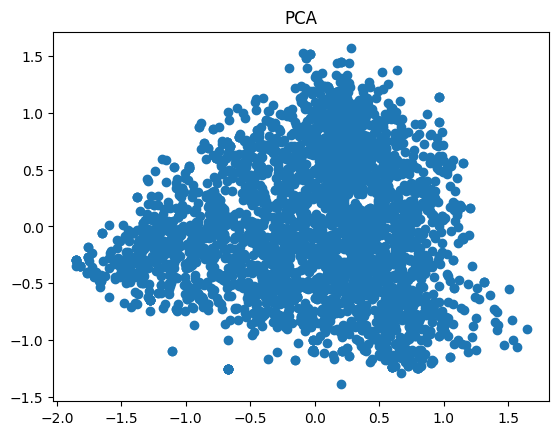

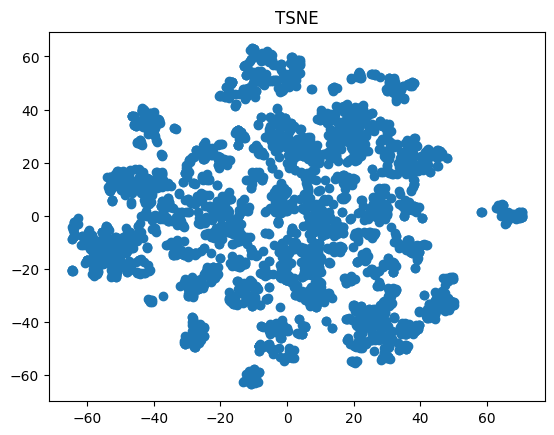

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


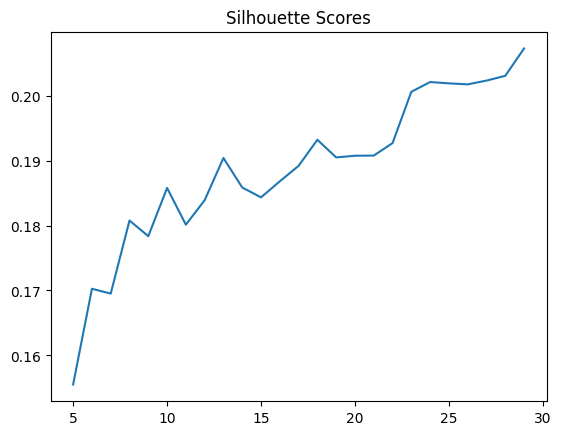

NMI: 0.24528370148789036


In [1290]:
perform_kmeans(w2v_embeddings_all)

In [1302]:
run_kmeans_best_k(13, w2v_embeddings_all)

Cluster 1 :
Cluster Size:========= 495
Sample Docs:=========
engine fan speed resistor failure
control valve is falling off
turbo pressure PSI constant
lube system failure
radiator blocked by grass

Top words:=========
unserviceable
pump
leaking
on
air

Top failure modes:=========
unserviceable
leaking
failed
not working
faulty

Top equipment:=========
pump
PTO
seal
shaft
engine

Inherent functions in order:
generating (62)
guiding (55)
protecting (53)
controlling (45)
sensing (43)
transforming (41)
holding (39)
covering (30)
driving (28)
emitting (24)
interfacing (23)
presenting (22)
matterprocessing (12)
storing (9)
restricting (6)
humaninteraction (3)

Cluster 2 :
Cluster Size:========= 205
Sample Docs:=========
replacing needed for auto-greaser door window
window frame needs
drivers door hinges worn out
faulty seat
drivers window has a fault

Top words:=========
window
cabin
door
broken
seat

Top failure modes:=========
broken
damaged
cracked
unserviceable
faulty

Top equipment:===

### Ave Hierarchical

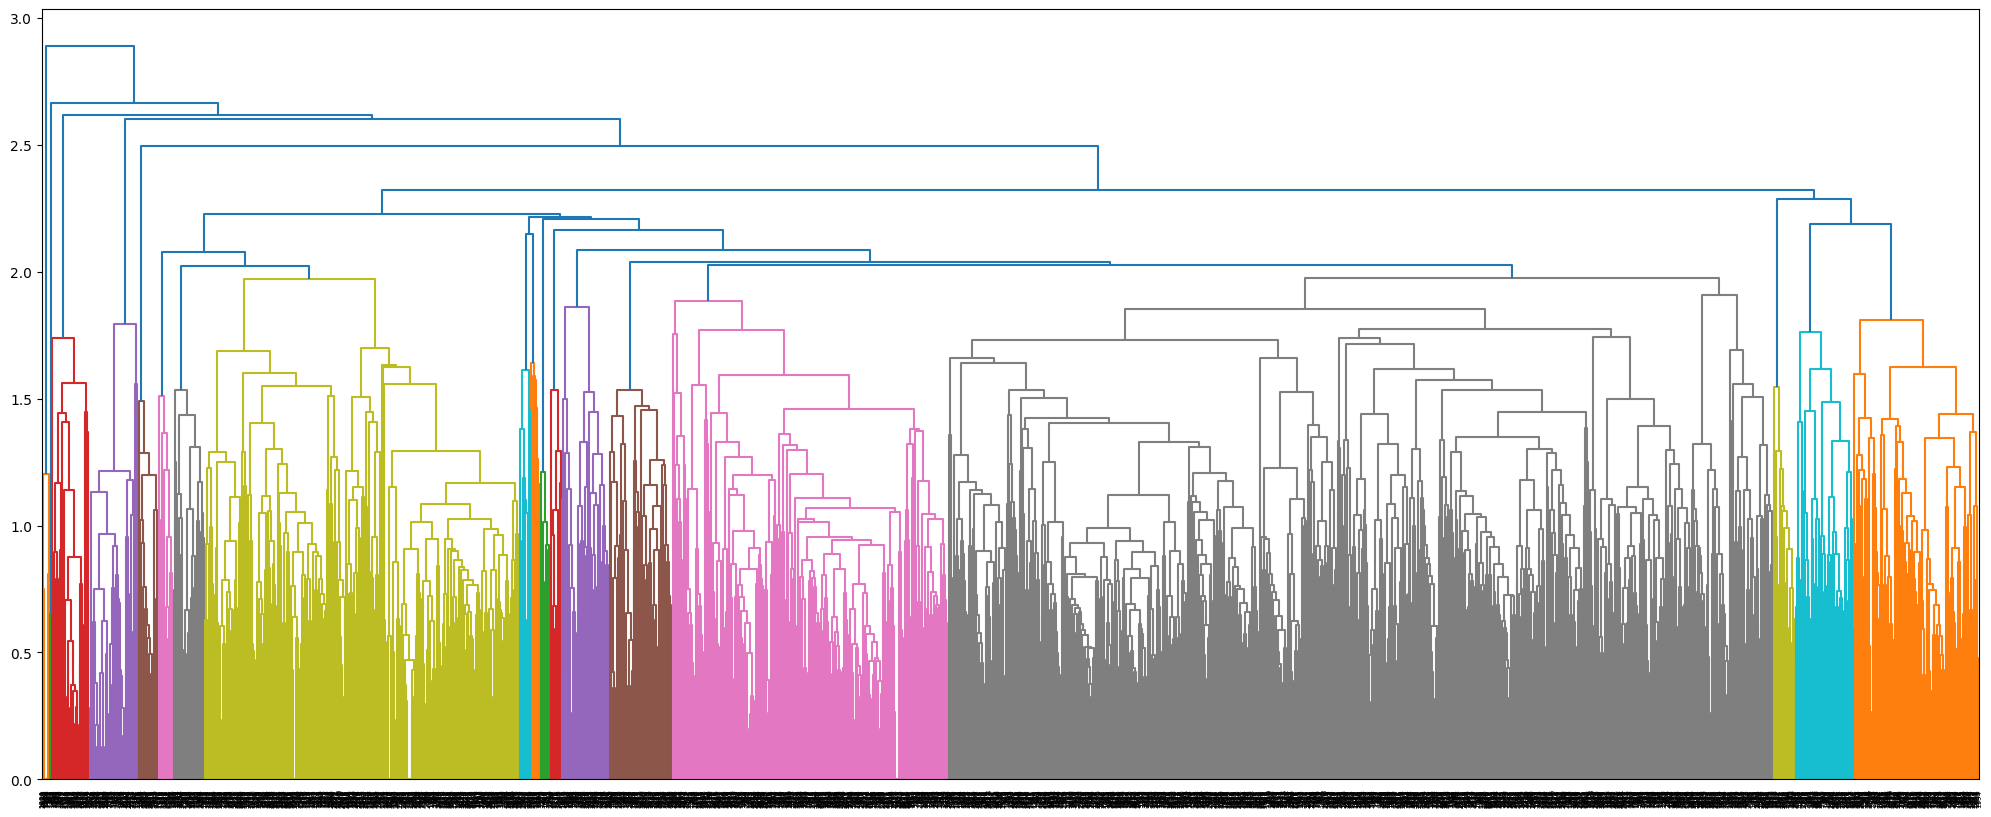

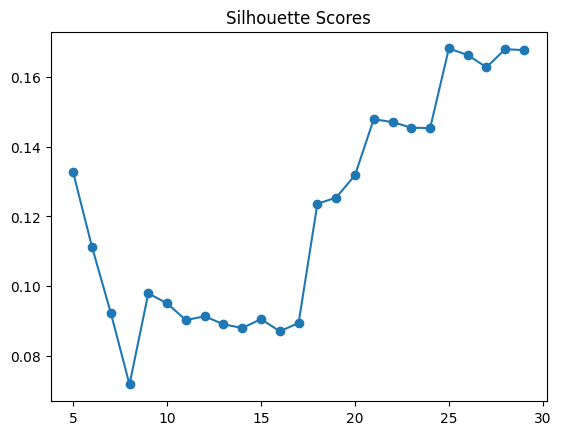

NMI: 0.18302476309577487


In [1291]:
linkage_data_ave = perform_hierarchical_clustering(w2v_embeddings_all, "average")

In [1303]:
get_hierarchical_clusters(18, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 13
Sample Docs:=========
engine overheating
engine overheating
engine overheating
engine overheating
engine overheating
transmission overheating
engine overheating
engine overheating text
overheating engine fault
transmission overheating fault

Top words:=========
overheating
engine
transmission
fault
text

Top failure modes:=========
overheating
fault
overheating fault

Top equipment:=========
engine
transmission

Inherent functions in order:
driving (10)
transforming (3)

Cluster 2 :
Cluster Size:========= 4
Sample Docs:=========
starter isolator seized
seized isolator
starter isolator seized
seized isolator

Top words:=========
isolator
seized
starter

Top failure modes:=========
seized

Top equipment:=========
isolator
starter

Inherent functions in order:
controlling (4)

Cluster 3 :
Cluster Size:========= 60
Sample Docs:=========
batteries need charging
no charge in batteries
inverter batteries are not charged
inverter earthing out
batteries hav

### Ward Heirarchical

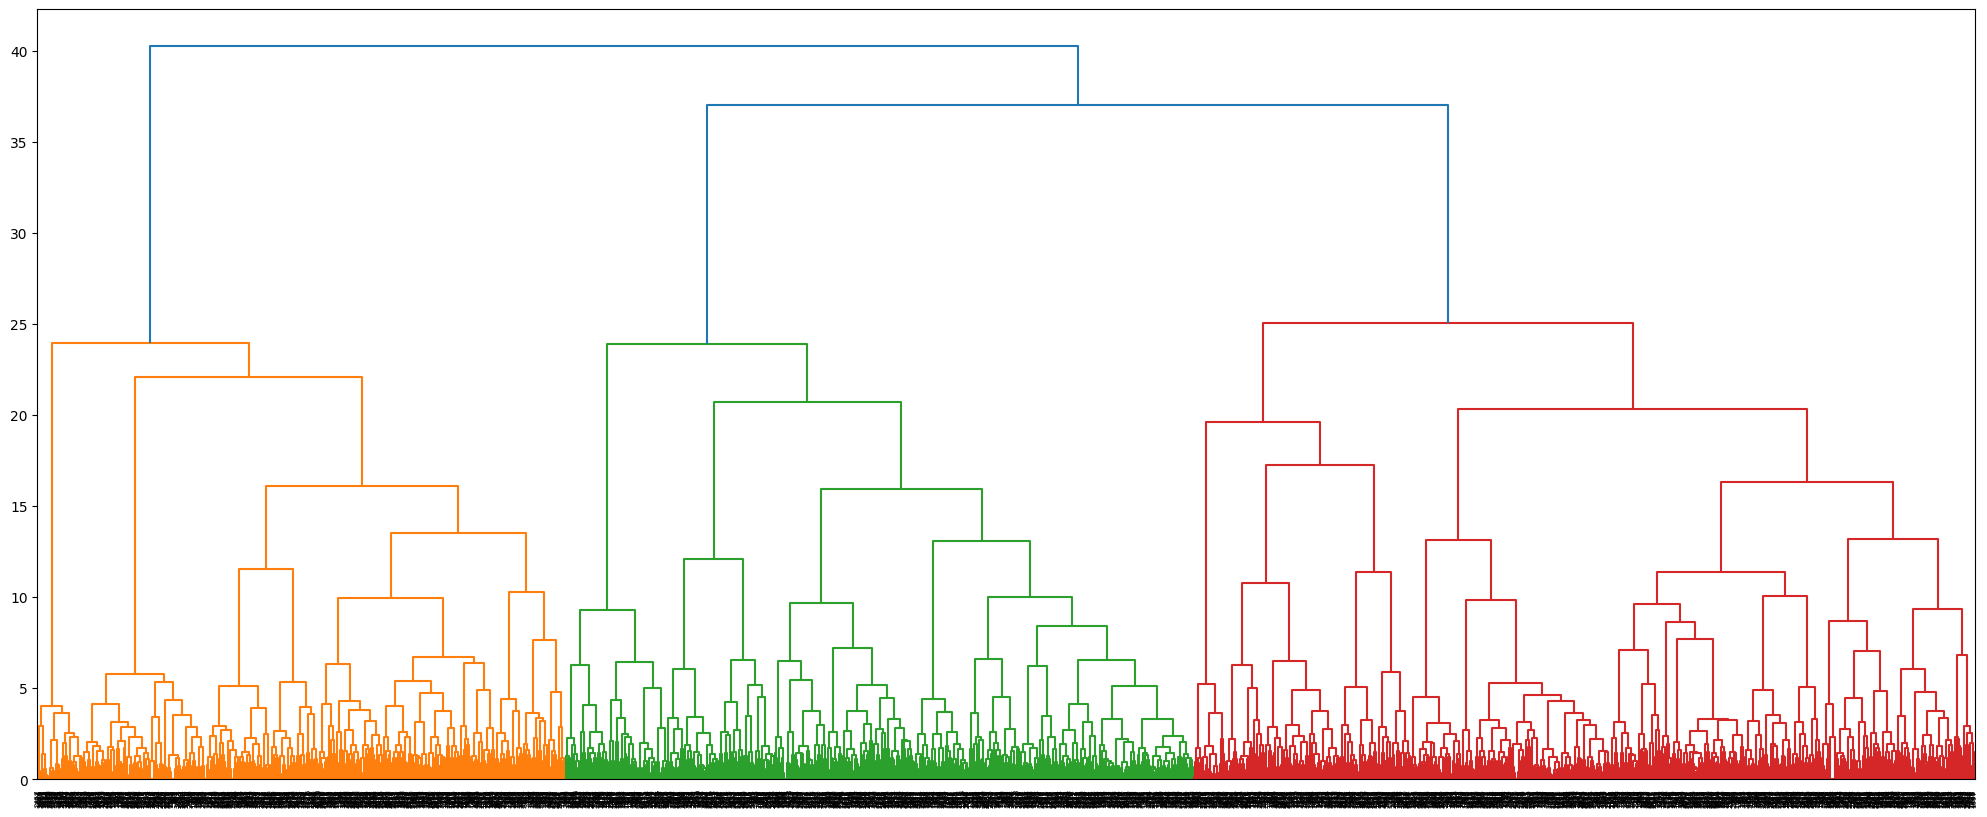

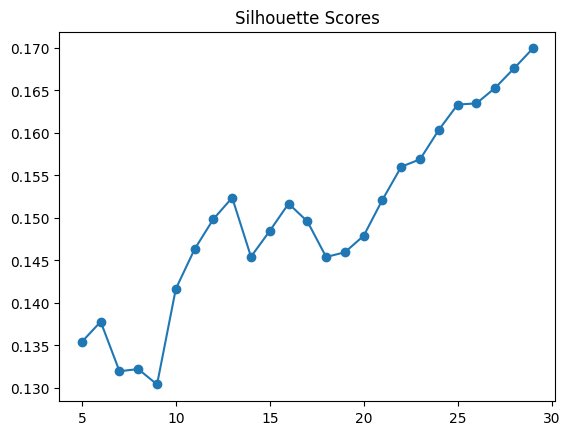

NMI: 0.24204393150383777


In [1292]:
linkage_data_ward = perform_hierarchical_clustering(w2v_embeddings_all, "ward")

In [1306]:
get_hierarchical_clusters(13, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 73
Sample Docs:=========
damaged tyre position
damage to position tyre
position tyre unserviceable
position flat tyre
blown position tyre
position tyre blown
flat tyre
damaged position guard
position guard damage
position tyre under inflated

Top words:=========
position
tyre
damaged
damage
flat

Top failure modes:=========
damaged
damage
flat
blown
worn

Top equipment:=========
tyre
guard
tyres
rim
hub

Inherent functions in order:
guiding (60)
protecting (8)
holding (5)

Cluster 2 :
Cluster Size:========= 202
Sample Docs:=========
coolant leaks
minor leak differential housing filter
steering oil leakage
minor transmission oil leak
oil leak from differential filter
oil leak pilot filter text
coolant leak near engine front
position inside oil leak
oil leak at pony drive pinion drag
oil leak

Top words:=========
leak
oil
engine
coolant
minor

Top failure modes:=========
leak
leaks
leaking
found
transferring

Top equipment:=========
oil
engine
coolant
p

## SBERT Clustering

In [1293]:
SBERT_embeddings_all = sbert.encode(X_train+X_test)

### K-means

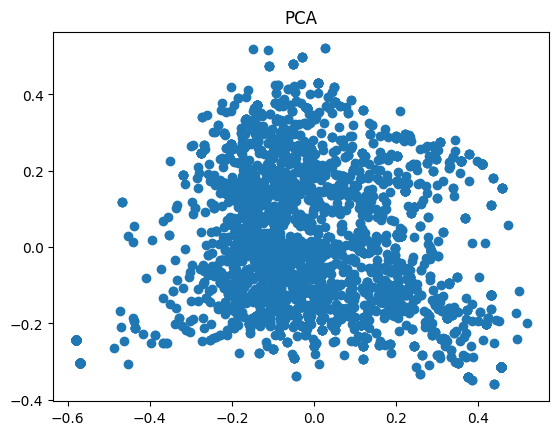

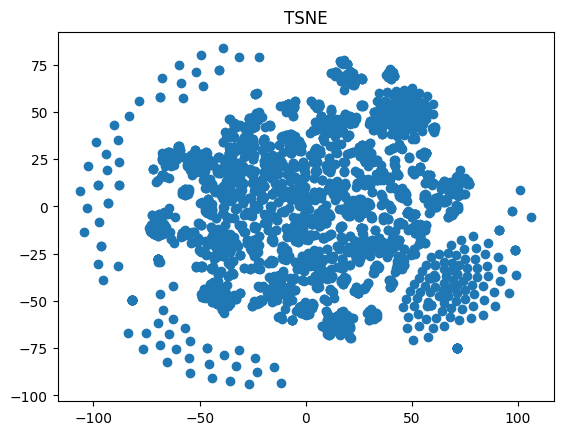

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


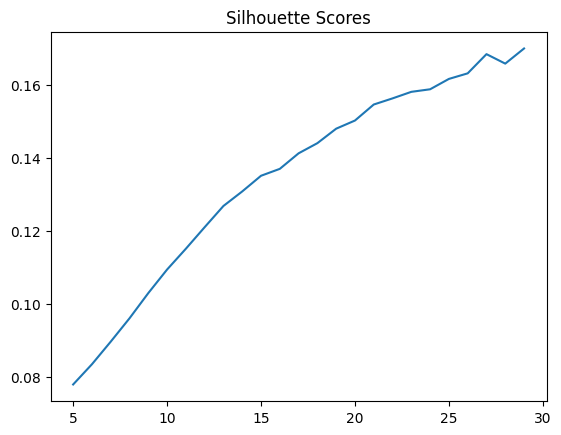

NMI: 0.14530974533454702


In [1294]:
perform_kmeans(SBERT_embeddings_all)

In [1307]:
run_kmeans_best_k(15, SBERT_embeddings_all)

Cluster 1 :
Cluster Size:========= 155
Sample Docs:=========
no power in cabin
light fault
dash lights keep staying on
headlight out light
roof lights not working

Top words:=========
lights
out
light
on
batteries

Top failure modes:=========
out
not working
no charge
fault
unserviceable

Top equipment:=========
lights
light
batteries
battery
boom

Inherent functions in order:
emitting (90)
generating (24)
holding (8)
storing (8)
protecting (6)
sensing (5)
controlling (4)
presenting (2)
humaninteraction (2)
covering (2)
guiding (2)
restricting (1)
transforming (1)

Cluster 2 :
Cluster Size:========= 141
Sample Docs:=========
blown hydraulic hose on boom
blow by fault on engine
replace blown air conditioner hose o-ring
blown hose
air horn fault

Top words:=========
blown
hose
air
o-ring
on

Top failure modes:=========
blown
not working
missing
needs replaced
keeps blowing

Top equipment:=========
hose
o-ring
air conditioner
horn
air horn

Inherent functions in order:
guiding (71)
coveri

### Ave Hierarchical

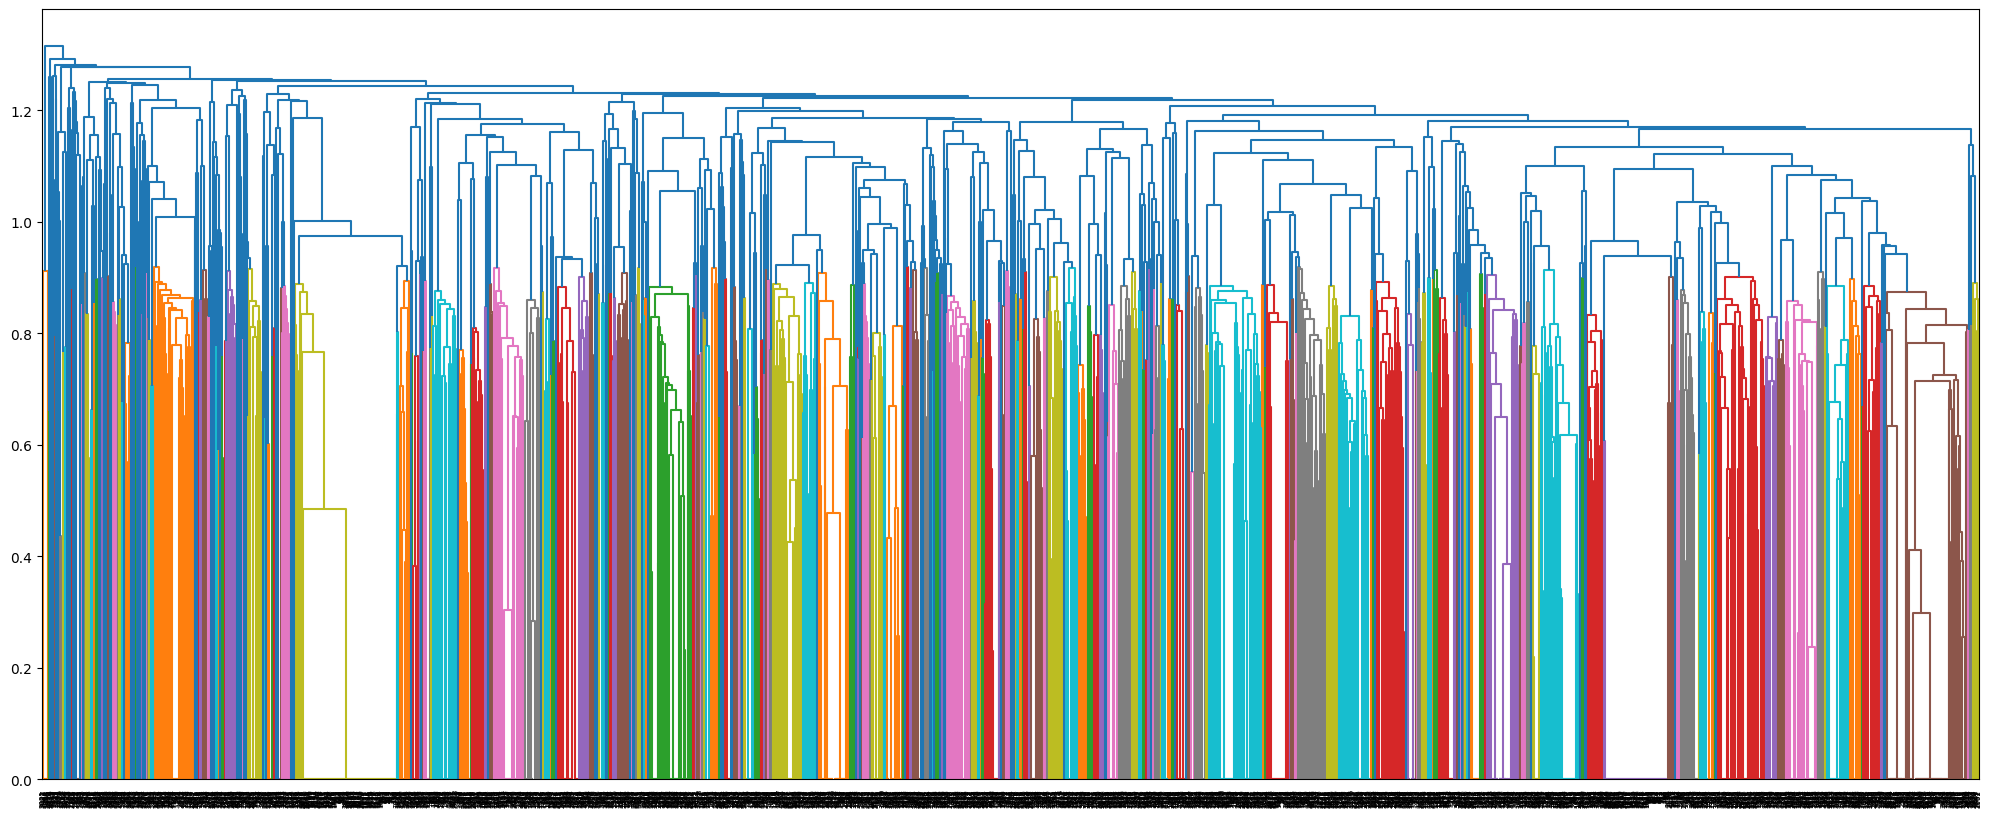

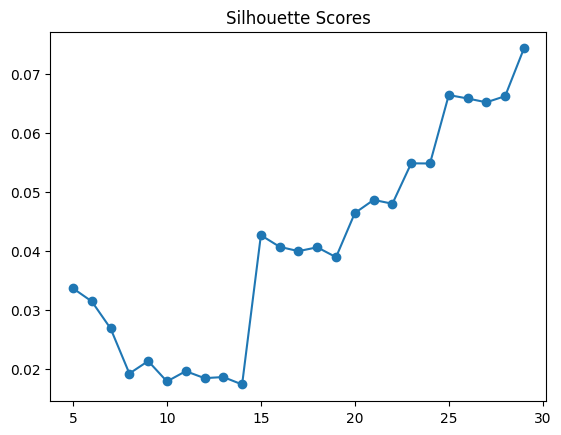

NMI: 0.0646007050087649


In [1308]:
linkage_data_ave = perform_hierarchical_clustering(SBERT_embeddings_all, "average")

In [1310]:
get_hierarchical_clusters(15, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 11
Sample Docs:=========
vims keypad light remains out
VIMS keypad light out
replace vims keypad light out
vims keypad light found out
VIMS keypad backlight blown
vims keypad light needs cleaning out
VIMS error
vims keypad light needs clean out
vims keypad light is out
vims keypad light needs a clean out

Top words:=========
keypad
light
out
vims
VIMS

Top failure modes:=========
out
needs clean out
error
blown

Top equipment:=========
vims keypad light
VIMS
keypad
backlight
light

Inherent functions in order:
emitting (10)
presenting (1)

Cluster 2 :
Cluster Size:========= 2
Sample Docs:=========
PCR room air conditioner fault
PCR air conditioner wiring burnt out

Top words:=========
PCR
air
conditioner
wiring
burnt

Top failure modes:=========
burnt out
fault

Top equipment:=========
air conditioner
wiring

Inherent functions in order:
guiding (1)
emitting (1)

Cluster 3 :
Cluster Size:========= 4
Sample Docs:=========
controller filter worn out
env

### Ward Hierarchical

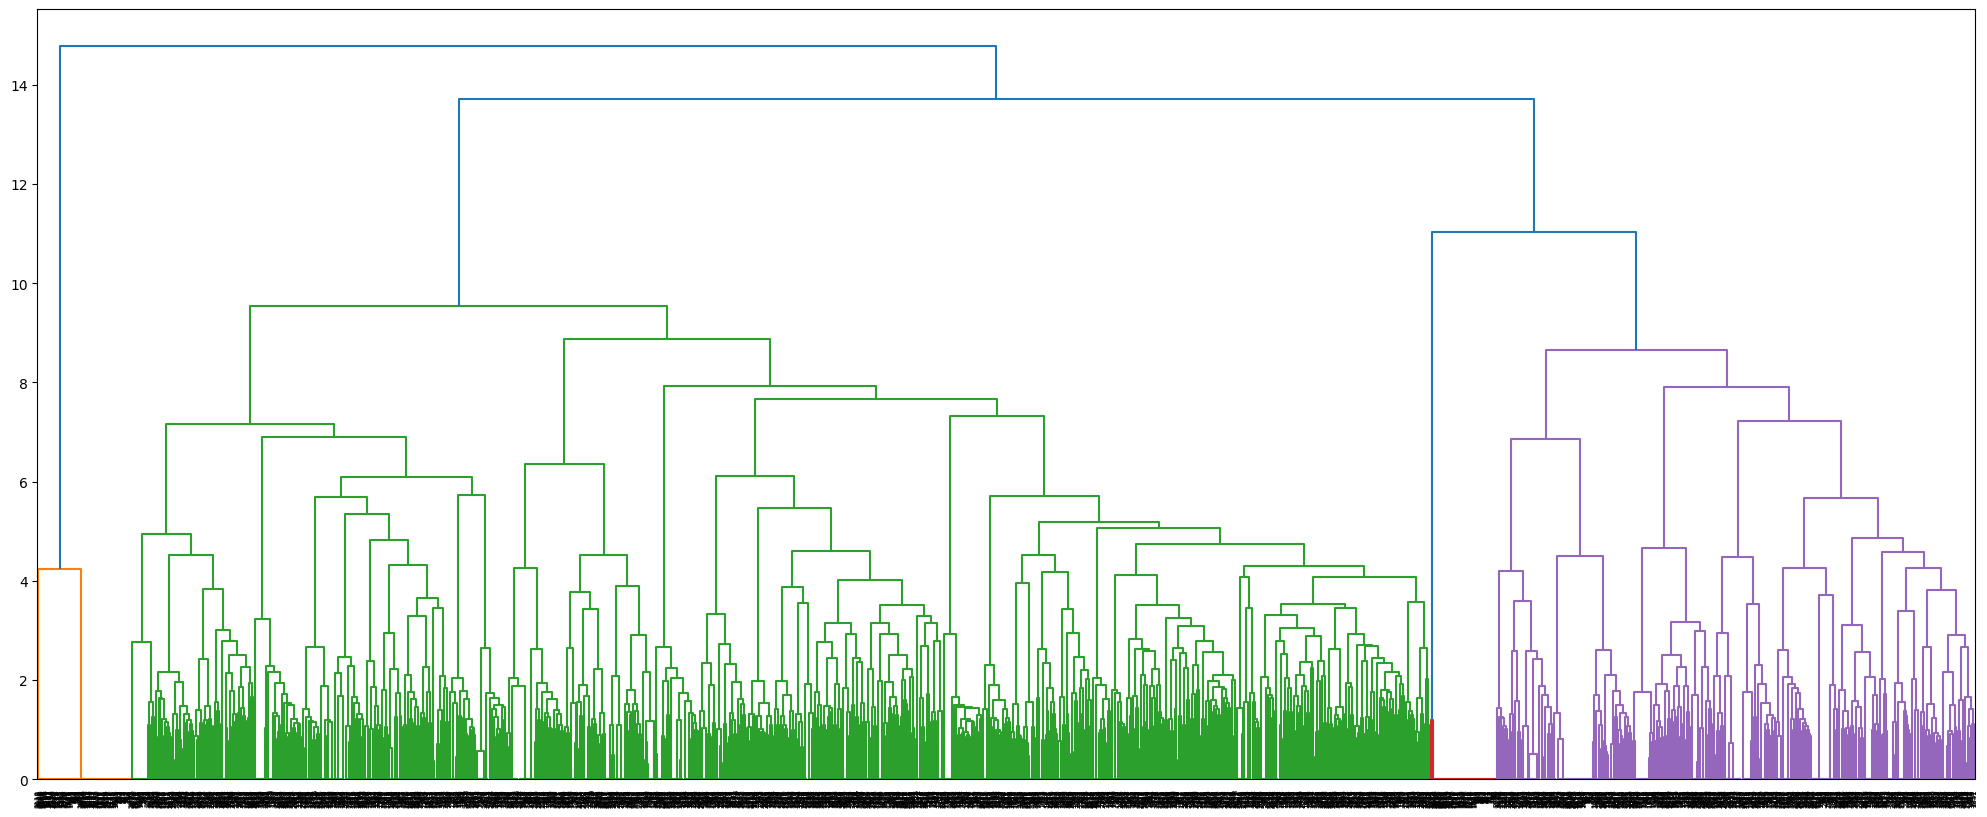

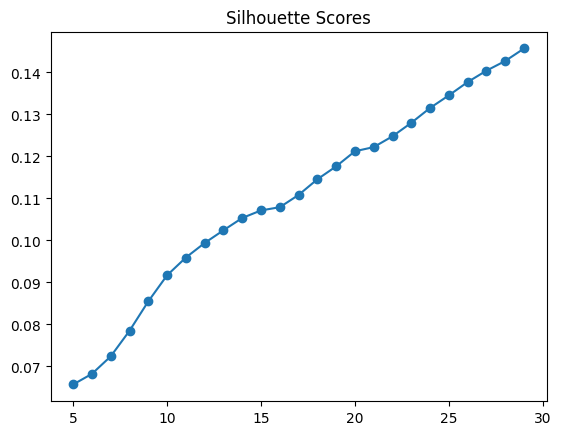

NMI: 0.12863992347025982


In [1309]:
linkage_data_ward = perform_hierarchical_clustering(SBERT_embeddings_all, "ward")

In [1312]:
get_hierarchical_clusters(15, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 153
Sample Docs:=========
right hand stick cylinder weeping
left hand exhaust manifold leak
right hand centre tray light fail
left hand side large air tank fitting leaking
right hand scoreboard not working
right hand dump rope snapped
right hand side propel filter needs
right hand side drag chain broken
right hand front light blown
left hand broken mirror

Top words:=========
hand
right
left
side
broken

Top failure modes:=========
broken
unserviceable
leaking
loose
missing

Top equipment:=========
cylinder
light
headlight
bolts
chain

Inherent functions in order:
holding (47)
guiding (24)
emitting (24)
driving (13)
controlling (8)
storing (7)
interfacing (6)
protecting (6)
covering (6)
matterprocessing (4)
humaninteraction (3)
sensing (2)
generating (1)
restricting (1)
presenting (1)

Cluster 2 :
Cluster Size:========= 199
Sample Docs:=========
flat position tyre
position oil leak inside hub
position grease line plate missing
position tyre damage
top

## w2v -> Inherent Function

### Create Cluster Embeddings

In [1144]:
# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(10,100)),
#     tf.keras.layers.Conv1D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPool1D(3),
#     tf.keras.layers.Conv1D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPool1D(3),
#     tf.keras.layers.Conv1D(128, 3, activation='relu'),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(16, activation='softmax')
# ])

# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (2,2), padding="same", input_shape=(10,100,1), use_bias=False),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation("relu"),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     # tf.keras.layers.Conv2D(8, (2,2), padding="same", use_bias=False),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Activation("relu"),
#     # tf.keras.layers.MaxPool2D(pool_size=2),
    
#     tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(units=128),
#     # tf.keras.layers.Activation("tanh"),
#     tf.keras.layers.Dense(units=10),
#     tf.keras.layers.Activation("tanh"),
#     tf.keras.layers.Dense(units=17, activation="softmax")
# ])
# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (2,2), padding="same", input_shape=(10,100,1), use_bias=False),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=64, activation="tanh"),
    
#     tf.keras.layers.Dense(units=10, activation="tanh"),
#     tf.keras.layers.Dense(units=16, activation="softmax")
# ])

w2v_if_model = tf.keras.Sequential([
    # tf.keras.layers.LSTM(64, input_shape=(10,100)),
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(units=16, activation="softmax")
])
# model.summary()
# w2v_if_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(10,100,1)),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
#     tf.keras.layers.MaxPool2D(pool_size=2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=10, activation="tanh"),
#     tf.keras.layers.Dense(units=16, activation="softmax")
# ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
class_weight = {}
for i in MWO_by_function.keys():
    class_weight[class_list.index(i)] = len(MWO_by_function[i])/len(dataset)

w2v_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = w2v_if_model.fit(w2v_embeddings_X_train, y_train, epochs=200, validation_data=(w2v_embeddings_X_test, y_test), callbacks=[early_stopping], class_weight=class_weight)

# run predictions
pred_train = w2v_if_model.predict(w2v_embeddings_X_train)
pred_train = pred_train.argmax(axis=-1)
print("Final train accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_train, y_train)[1])

pred_test = w2v_if_model.predict(w2v_embeddings_X_test)
pred_test = pred_test.argmax(axis=-1)
print("Final test accuracy:", w2v_if_model.evaluate(w2v_embeddings_X_test, y_test)[1])

Epoch 1/200
79/79 [==============================] - 5s 17ms/step - loss: 0.1859 - accuracy: 0.2266 - val_loss: 2.2637 - val_accuracy: 0.3090
Epoch 2/200
79/79 [==============================] - 1s 7ms/step - loss: 0.1380 - accuracy: 0.3631 - val_loss: 2.0946 - val_accuracy: 0.3883
Epoch 3/200
79/79 [==============================] - 1s 7ms/step - loss: 0.1191 - accuracy: 0.4333 - val_loss: 1.9264 - val_accuracy: 0.4089
Epoch 4/200
79/79 [==============================] - 1s 6ms/step - loss: 0.1054 - accuracy: 0.4837 - val_loss: 1.8438 - val_accuracy: 0.4628
Epoch 5/200
79/79 [==============================] - 1s 6ms/step - loss: 0.0966 - accuracy: 0.5183 - val_loss: 1.9075 - val_accuracy: 0.4295
Epoch 6/200
79/79 [==============================] - 1s 8ms/step - loss: 0.0906 - accuracy: 0.5480 - val_loss: 1.6601 - val_accuracy: 0.5357
Epoch 7/200
79/79 [==============================] - 1s 7ms/step - loss: 0.0837 - accuracy: 0.5917 - val_loss: 1.6941 - val_accuracy: 0.5293
Epoch 8/200


In [1146]:
# get hidden layer model 
# w2v_if_model_embedding = tf.keras.Sequential([
    
#     tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(10,100,1)),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
#     tf.keras.layers.MaxPool2D(pool_size=2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=10, activation="tanh"),
# ])
w2v_if_model_embedding = tf.keras.Sequential([
    # tf.keras.layers.LSTM(64, input_shape=(10,100)),
    tf.keras.layers.Input(shape=(10,100)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu')
])

# w2v_if_model_embedding.layers[0].set_weights(w2v_if_model.layers[0].get_weights())
# w2v_if_model_embedding.layers[2].set_weights(w2v_if_model.layers[2].get_weights())
# w2v_if_model_embedding.layers[5].set_weights(w2v_if_model.layers[5].get_weights())

w2v_if_model_embedding.layers[0].set_weights(w2v_if_model.layers[0].get_weights())
w2v_if_model_embedding.layers[1].set_weights(w2v_if_model.layers[1].get_weights())
w2v_if_model_embedding.layers[2].set_weights(w2v_if_model.layers[2].get_weights())
w2v_if_model_embedding.layers[3].set_weights(w2v_if_model.layers[3].get_weights())


w2v_embeddings = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
cluster_embeddings = w2v_if_model_embedding.predict(w2v_embeddings)
print(cluster_embeddings.shape)


99/99 [==============================] - 1s 2ms/step
(3151, 10)


### K-means

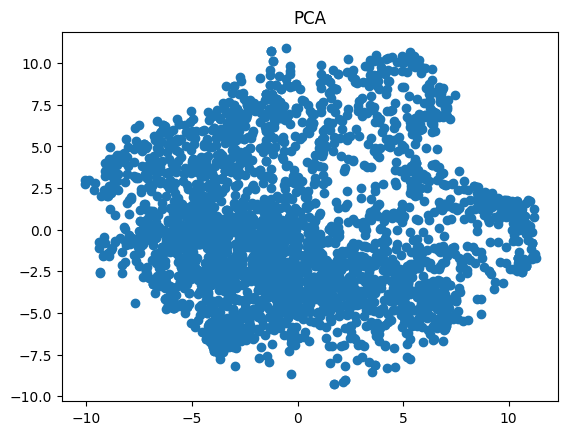

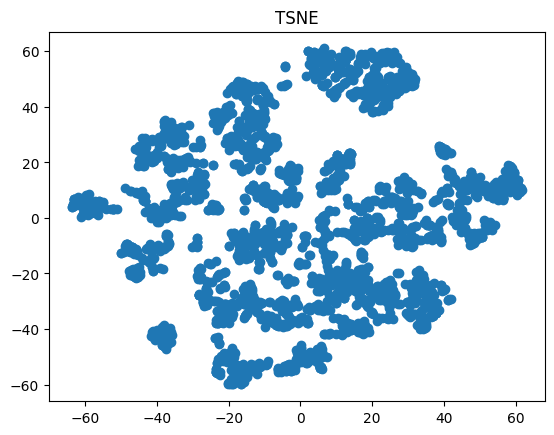

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


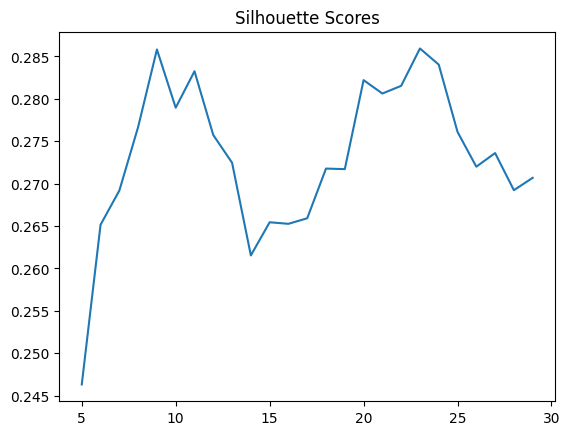

In [1147]:
perform_kmeans(cluster_embeddings)

In [1189]:
run_kmeans_best_k(9, cluster_embeddings)

NMI: 0.523958093617919
Cluster 1 :
Cluster Size:========= 673
Sample Docs:=========
headboard supports bent
chord is leaking air from crack
reported bucket arch cracking
broken AFFF bracket
steering wheel cover missing

Top words:=========
broken
cracked
window
hand
cabin

Top failure modes:=========
broken
cracked
crack
missing
worn

Top equipment:=========
window
door
oil
bucket
tank

Inherent functions in order:
controlling (180)
protecting (96)
matterprocessing (93)
storing (87)
holding (72)
covering (41)
interfacing (35)
restricting (31)
humaninteraction (12)
guiding (10)
presenting (7)
transforming (2)
sensing (2)
generating (2)
emitting (2)
driving (1)

Cluster 2 :
Cluster Size:========= 241
Sample Docs:=========
oil leak on drag
oil leak at fitting
oil leak at implement pump mount
hydraulic oil leak at axle
leak in pilot valve solenoid

Top words:=========
leak
oil
fuse
system
grease

Top failure modes:=========
leak
fault
keeps blowing
found
keep blowing

Top equipment:=======

### Ave Hierarchical

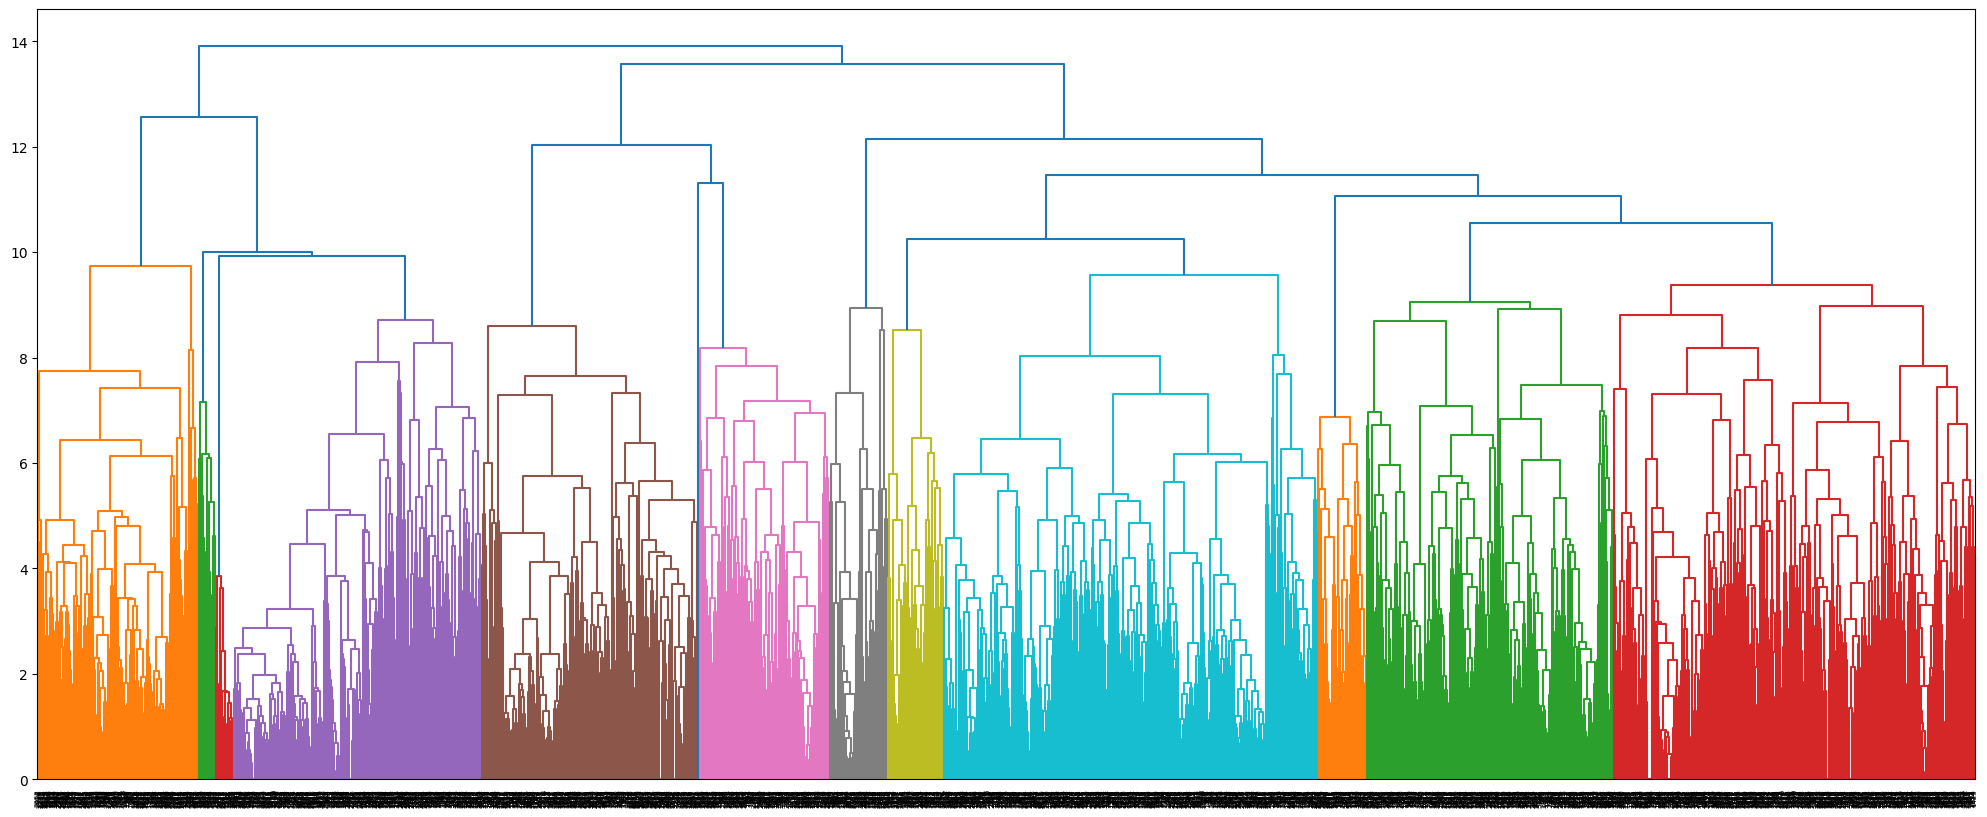

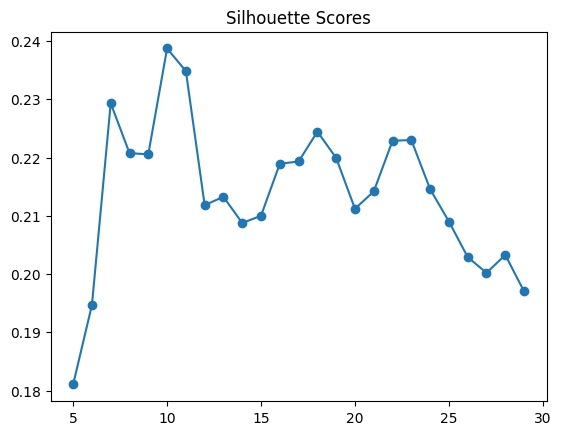

NMI: 0.5149832052793822


In [1149]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings, "average")

In [1186]:
get_hierarchical_clusters(10, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 262
Sample Docs:=========
bolt missing off radiator grill
track assembly idler pin coming out
transmission filling with hydraulic oil
hoist equaliser broken rope off sheave
missing muffler mount bolt

Top words:=========
missing
bolts
pin
broken
hand

Top states:=========
missing
broken
loose
unserviceable
coming out

Top equipment:=========
bolts
pin
bolt
bearing
rope

Inherent functions in order:
holding (229)
controlling (8)
covering (7)
transforming (4)
storing (4)
guiding (3)
interfacing (2)
matterprocessing (1)
restricting (1)
sensing (1)
protecting (1)
presenting (1)

Cluster 2 :
Cluster Size:========= 461
Sample Docs:=========
cable required
pulley unserviceable
tracks loose
position tyre mismatch
air conditioner hose stolen for

Top words:=========
hose
blown
position
leaking
tyre

Top states:=========
blown
leaking
unserviceable
damaged
broken

Top equipment:=========
hose
tyre
brake
steering
pulley

Inherent functions in order:
guiding (388

In [1152]:
get_hierarchical_clusters(18, linkage_data_ave)

Cluster 1 :
Cluster Size: 245
Top words:
   missing
   bolts
   pin
   broken
   hand

Top states:
   missing
   broken
   loose
   unserviceable
   coming out

Top equipment:
   bolts
   pin
   bolt
   bearing
   rope

Inherent functions in order:
   holding 222
   covering 6
   transforming 3
   storing 3
   guiding 2
   interfacing 2
   controlling 2
   matterprocessing 1
   restricting 1
   sensing 1
   protecting 1
   presenting 1
Cluster 2 :
Cluster Size: 17
Top words:
   steering
   transmission
   main
   breaker
   ropes

Top states:
   tripped
   require
   damaged
   falling off
   stripped

Top equipment:
   transmission
   steering
   ropes
   circuit breaker
   air tanks

Inherent functions in order:
   holding 7
   controlling 6
   storing 1
   transforming 1
   guiding 1
   covering 1
Cluster 3 :
Cluster Size: 28
Top words:
   belt
   air
   conditioner
   unserviceable
   wiring

Top states:
   unserviceable
   missing
   loose
   requires
   damaged

Top equipment:
  

### Ward Hierarchical

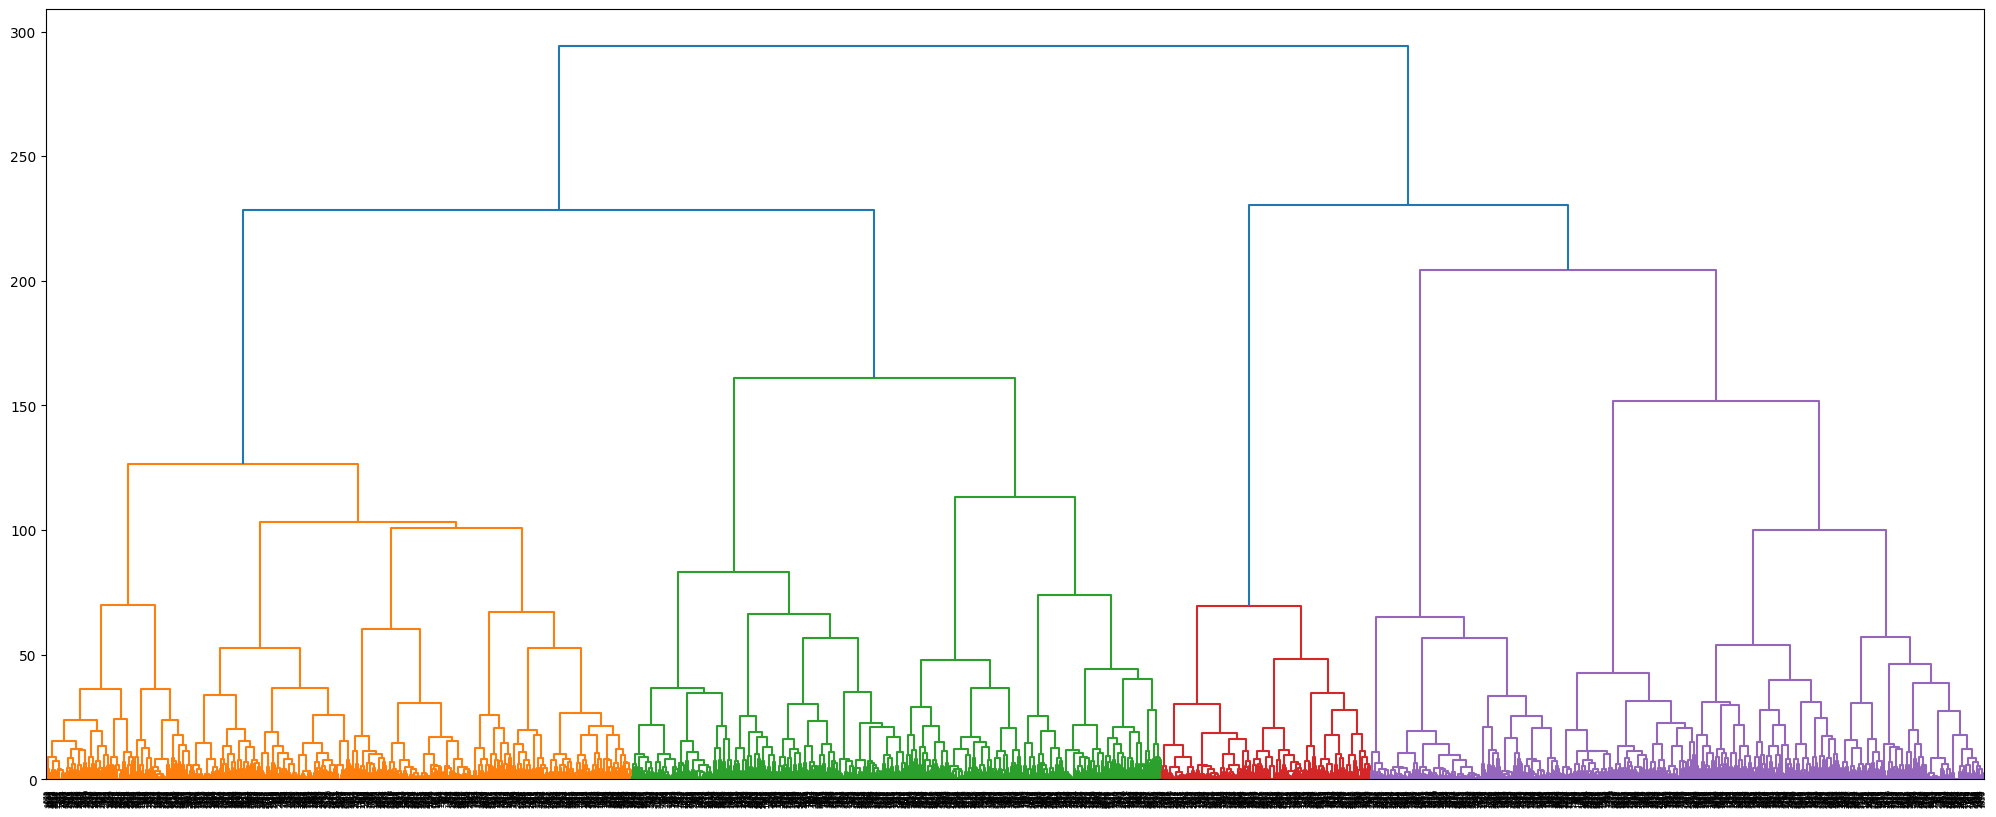

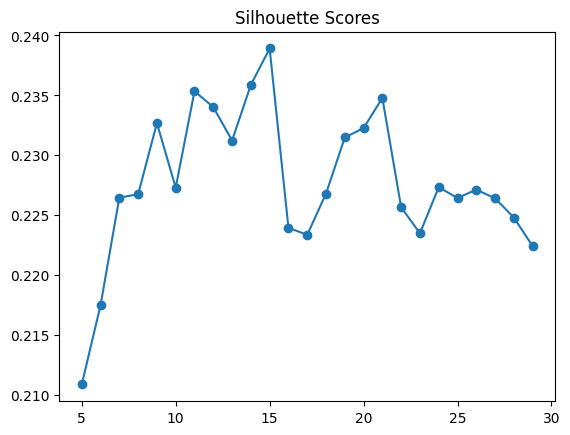

NMI: 0.5144121711074586


In [1150]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings, "ward")

In [1187]:
get_hierarchical_clusters(15, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 144
Sample Docs:=========
grease distributor leaking
fire suppression low on gauge PO
leak at hydraulic tank
grease leak on boom
lower air conditioner compressor guard crack

Top words:=========
leak
oil
coolant
engine
pump

Top states:=========
leak
found
leaks
needs repair
leaking

Top equipment:=========
oil
coolant
engine
hydraulic oil
pump

Inherent functions in order:
protecting (102)
interfacing (9)
transforming (7)
covering (5)
holding (4)
matterprocessing (3)
presenting (3)
generating (3)
emitting (2)
driving (2)
guiding (1)
restricting (1)
controlling (1)
storing (1)

Cluster 2 :
Cluster Size:========= 93
Sample Docs:=========
lights fuse has a fault
air pressure safety valve exhausting
fire suppression fault
wiper fuse is blowing
grease system fault

Top words:=========
fuse
system
blowing
fault
air

Top states:=========
fault
keeps blowing
keep blowing
weeping
faults

Top equipment:=========
grease system
fuse
operator cabin air conditione

In [1154]:
get_hierarchical_clusters(21, linkage_data_ward)

Cluster 1 :
Cluster Size: 144
Top words:
   leak
   oil
   coolant
   engine
   pump

Top states:
   leak
   found
   leaks
   needs repair
   leaking

Top equipment:
   oil
   coolant
   engine
   hydraulic oil
   pump

Inherent functions in order:
   protecting 102
   interfacing 9
   transforming 7
   covering 5
   holding 4
   matterprocessing 3
   presenting 3
   generating 3
   emitting 2
   driving 2
   guiding 1
   restricting 1
   controlling 1
   storing 1
Cluster 2 :
Cluster Size: 93
Top words:
   fuse
   system
   blowing
   fault
   air

Top states:
   fault
   keeps blowing
   keep blowing
   weeping
   faults

Top equipment:
   grease system
   fuse
   operator cabin air conditioner fuse
   fire system
   pressure compensator

Inherent functions in order:
   protecting 88
   holding 2
   generating 1
   emitting 1
   driving 1
Cluster 3 :
Cluster Size: 260
Top words:
   missing
   fuel
   worn
   bucket
   filter

Top states:
   missing
   worn
   broken
   crack
   leak

## SBERT -> Inherent Function

### Create Cluster Embeddings

In [1249]:
sbert_if_model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
class_weight = {}
for i in MWO_by_function.keys():
    class_weight[class_list.index(i)] = len(MWO_by_function[i])/len(dataset)

sbert_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = sbert_if_model.fit(SBERT_embeddings_train, y_train, epochs=200, validation_data=(SBERT_embeddings_test, y_test), callbacks=[early_stopping], class_weight=class_weight)

# do predictions
pred_train = sbert_if_model.predict(SBERT_embeddings_train)
pred_train = pred_train.argmax(axis=-1)
print("training accuracy", sbert_if_model.evaluate(SBERT_embeddings_train, y_train)[1])

pred_test = sbert_if_model.predict(SBERT_embeddings_test)
pred_test = pred_test.argmax(axis=-1)
print("test accuracy", sbert_if_model.evaluate(SBERT_embeddings_test, y_test)[1])


Epoch 1/200
79/79 [==============================] - 1s 4ms/step - loss: 0.1908 - accuracy: 0.2270 - val_loss: 2.4039 - val_accuracy: 0.2979
Epoch 2/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1595 - accuracy: 0.3266 - val_loss: 2.3204 - val_accuracy: 0.3185
Epoch 3/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1442 - accuracy: 0.3754 - val_loss: 2.1844 - val_accuracy: 0.3677
Epoch 4/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.4282 - val_loss: 2.1569 - val_accuracy: 0.3867
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.4659 - val_loss: 2.1732 - val_accuracy: 0.3914
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1172 - accuracy: 0.4901 - val_loss: 2.0797 - val_accuracy: 0.4342
Epoch 7/200
79/79 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.5171 - val_loss: 2.0620 - val_accuracy: 0.4279
Epoch 8/200
7

In [1250]:
# get hidden layer model 
sbert_if_model_embedding = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=128, activation="tanh", input_shape=(768,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    # tf.keras.layers.Dense(units=16, activation="softmax")
])


sbert_if_model_embedding.layers[0].set_weights(sbert_if_model.layers[0].get_weights())
sbert_if_model_embedding.layers[1].set_weights(sbert_if_model.layers[1].get_weights())
sbert_if_model_embedding.layers[2].set_weights(sbert_if_model.layers[2].get_weights())
sbert_if_model_embedding.layers[3].set_weights(sbert_if_model.layers[3].get_weights())
# sbert_if_model_embedding.layers[4].set_weights(sbert_if_model.layers[4].get_weights())


SBERT_embeddings = np.concatenate((SBERT_embeddings_train, SBERT_embeddings_test))
cluster_embeddings = sbert_if_model_embedding.predict(SBERT_embeddings)
print(cluster_embeddings.shape)


99/99 [==============================] - 0s 581us/step
(3151, 10)


### K-means

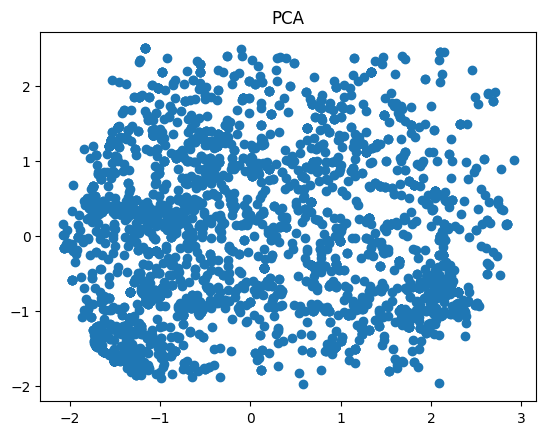

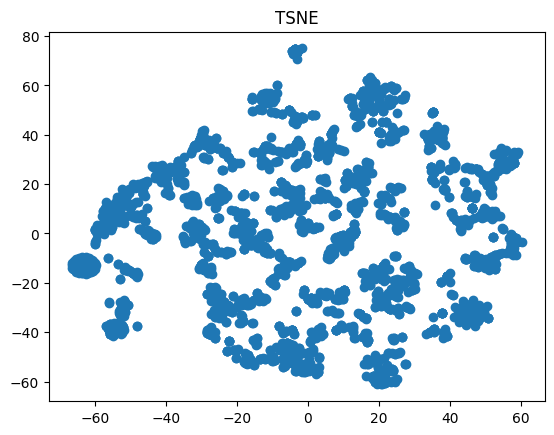

5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


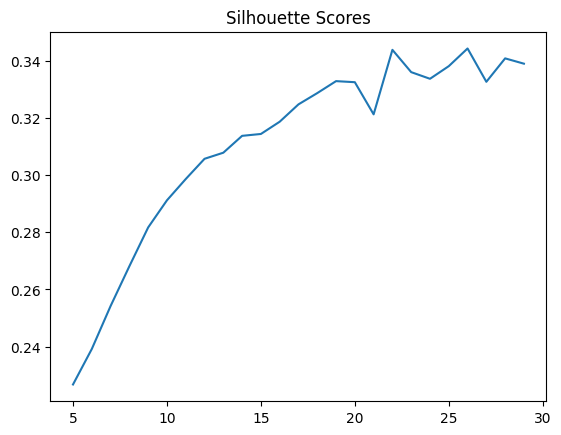

NMI: 0.4132233902480067


In [1274]:
perform_kmeans(cluster_embeddings)

In [1282]:
run_kmeans_best_k(14, cluster_embeddings)

Cluster 1 :
Cluster Size:========= 147
Sample Docs:=========
minor engine oil leaks at rear
engine overheating
engine overheating
unserviceable swing brake cylinder
unserviceable engine air conditioner

Top words:=========
engine
fault
unserviceable
motor
replace

Top failure modes:=========
fault
unserviceable
overheating
leak
vibration

Top equipment:=========
engine
motor
hoist
oil
propel

Inherent functions in order:
driving (93)
protecting (12)
emitting (9)
sensing (6)
generating (4)
controlling (4)
matterprocessing (1)
covering (1)
restricting (1)
presenting (1)
interfacing (1)
guiding (1)
transforming (1)
holding (1)

Cluster 2 :
Cluster Size:========= 167
Sample Docs:=========
cabin ladder light switch unserviceable
dust leak operators side window
small leak from sump gasket
fuel tank crack
issues with engine starting

Top words:=========
fuel
ladder
worn
on
o-ring

Top failure modes:=========
worn
blown
missing
unserviceable
cracked

Top equipment:=========
ladder
fuel tank
o-

### Ave Hierachical

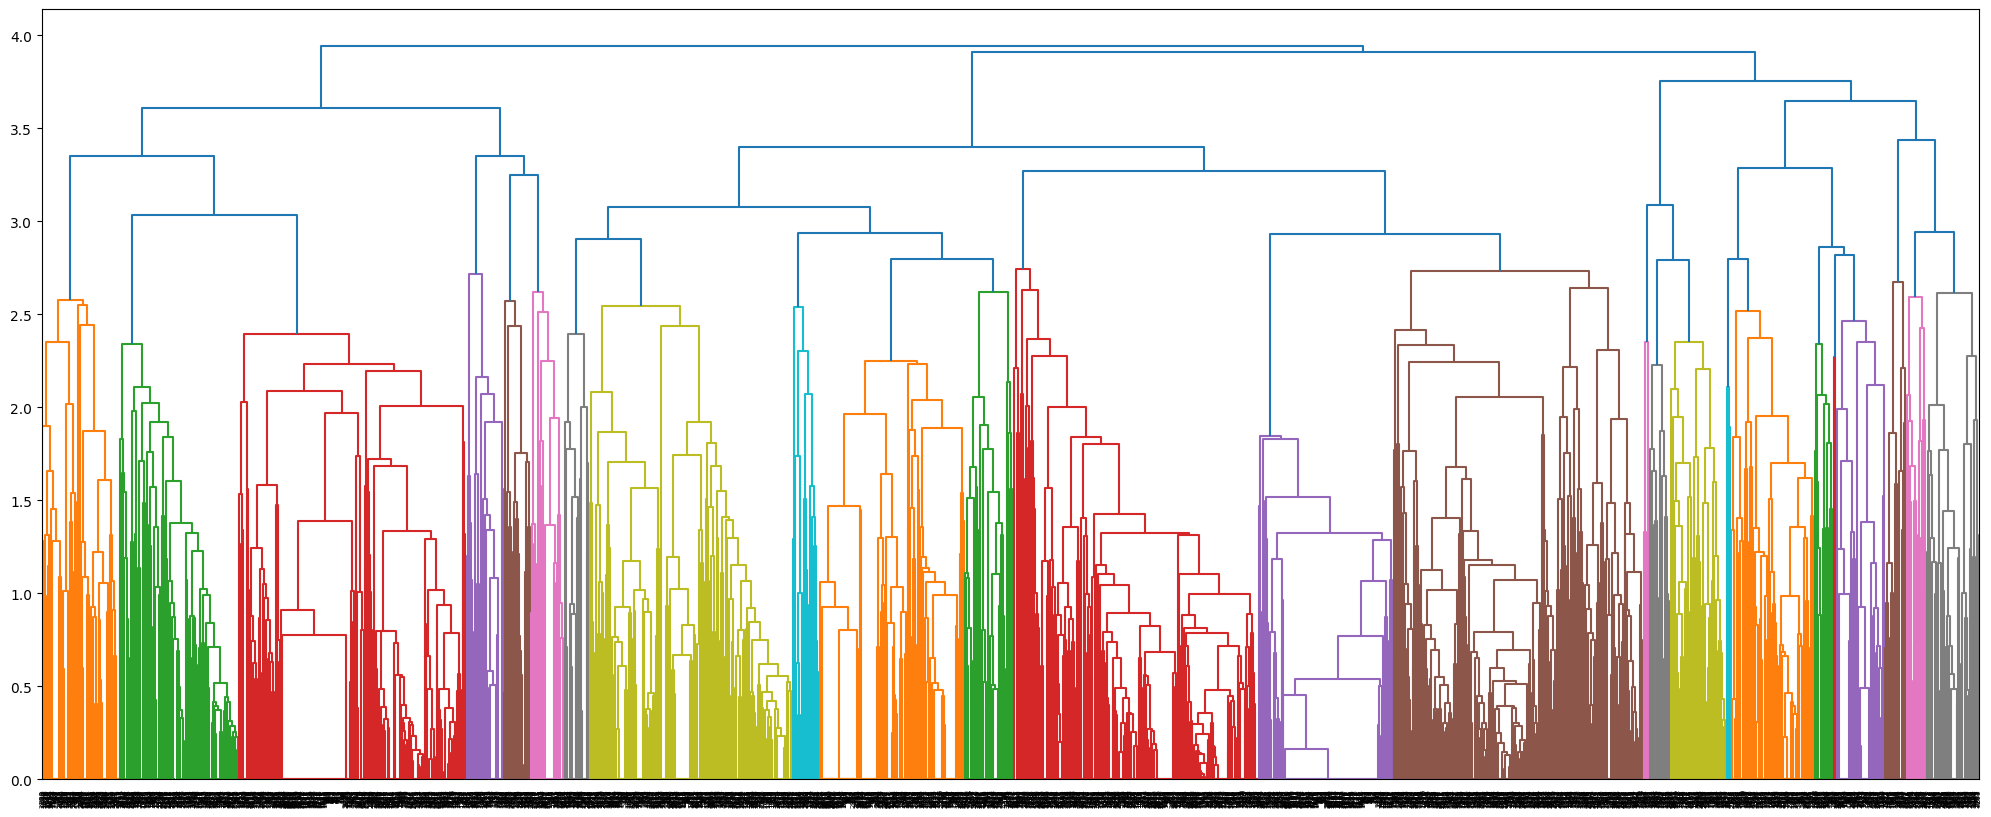

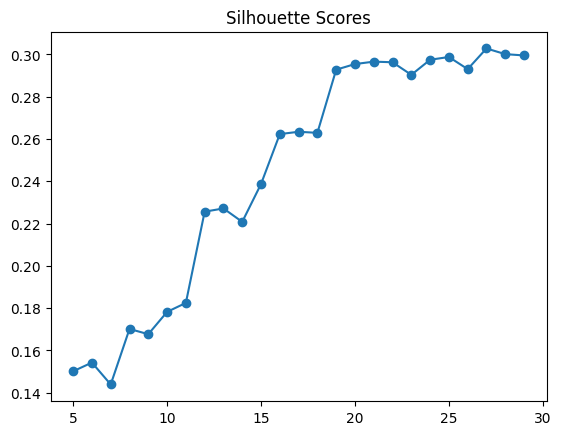

NMI: 0.40977379976562084


In [1251]:
linkage_data_ave = perform_hierarchical_clustering(cluster_embeddings, "average")

In [1283]:
get_hierarchical_clusters(16, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 126
Sample Docs:=========
engine will not run
engine not starting all the time
propel fault needs fixing
engine fault
synchronous motor left hand bearing overtemperature alarms
replace engine bay light
engine overheating
engine shutdown cable unserviceable
propel has a fault
engine will not fire

Top words:=========
engine
unserviceable
fault
motor
replace

Top failure modes:=========
unserviceable
fault
overheating
leak
vibration

Top equipment:=========
engine
motor
engine air conditioner
hoist
oil

Inherent functions in order:
driving (87)
emitting (10)
sensing (8)
generating (3)
protecting (3)
presenting (2)
controlling (2)
matterprocessing (2)
restricting (2)
covering (2)
guiding (2)
interfacing (1)
storing (1)
holding (1)

Cluster 2 :
Cluster Size:========= 194
Sample Docs:=========
compressor found not working
position turbo coolant leak
alternator unserviceable
faulty turbo
coolant pump not working
faulty alternator
air compressor unserviceabl

In [1284]:
get_hierarchical_clusters(19, linkage_data_ave)

Cluster 1 :
Cluster Size:========= 126
Sample Docs:=========
low engine power
engine overheating
engine will not run
engine speed sensor faults
synchronous motor not synchronising
replace unserviceable box coupling
VIMS error
blow by fault on engine
propel fault
engine will not start

Top words:=========
engine
unserviceable
fault
motor
replace

Top failure modes:=========
unserviceable
fault
overheating
leak
vibration

Top equipment:=========
engine
motor
engine air conditioner
hoist
oil

Inherent functions in order:
driving (87)
emitting (10)
sensing (8)
generating (3)
protecting (3)
presenting (2)
controlling (2)
matterprocessing (2)
restricting (2)
covering (2)
guiding (2)
interfacing (1)
storing (1)
holding (1)

Cluster 2 :
Cluster Size:========= 194
Sample Docs:=========
drag generator overvoltage alarms
inverter batteries are not charged
no charge in inverter batteries
alternator overcharged
<num>W/<num> pump filters requires
compressor safety valve leaking
hydraulic pump leak
d

### Ward Hierarchical

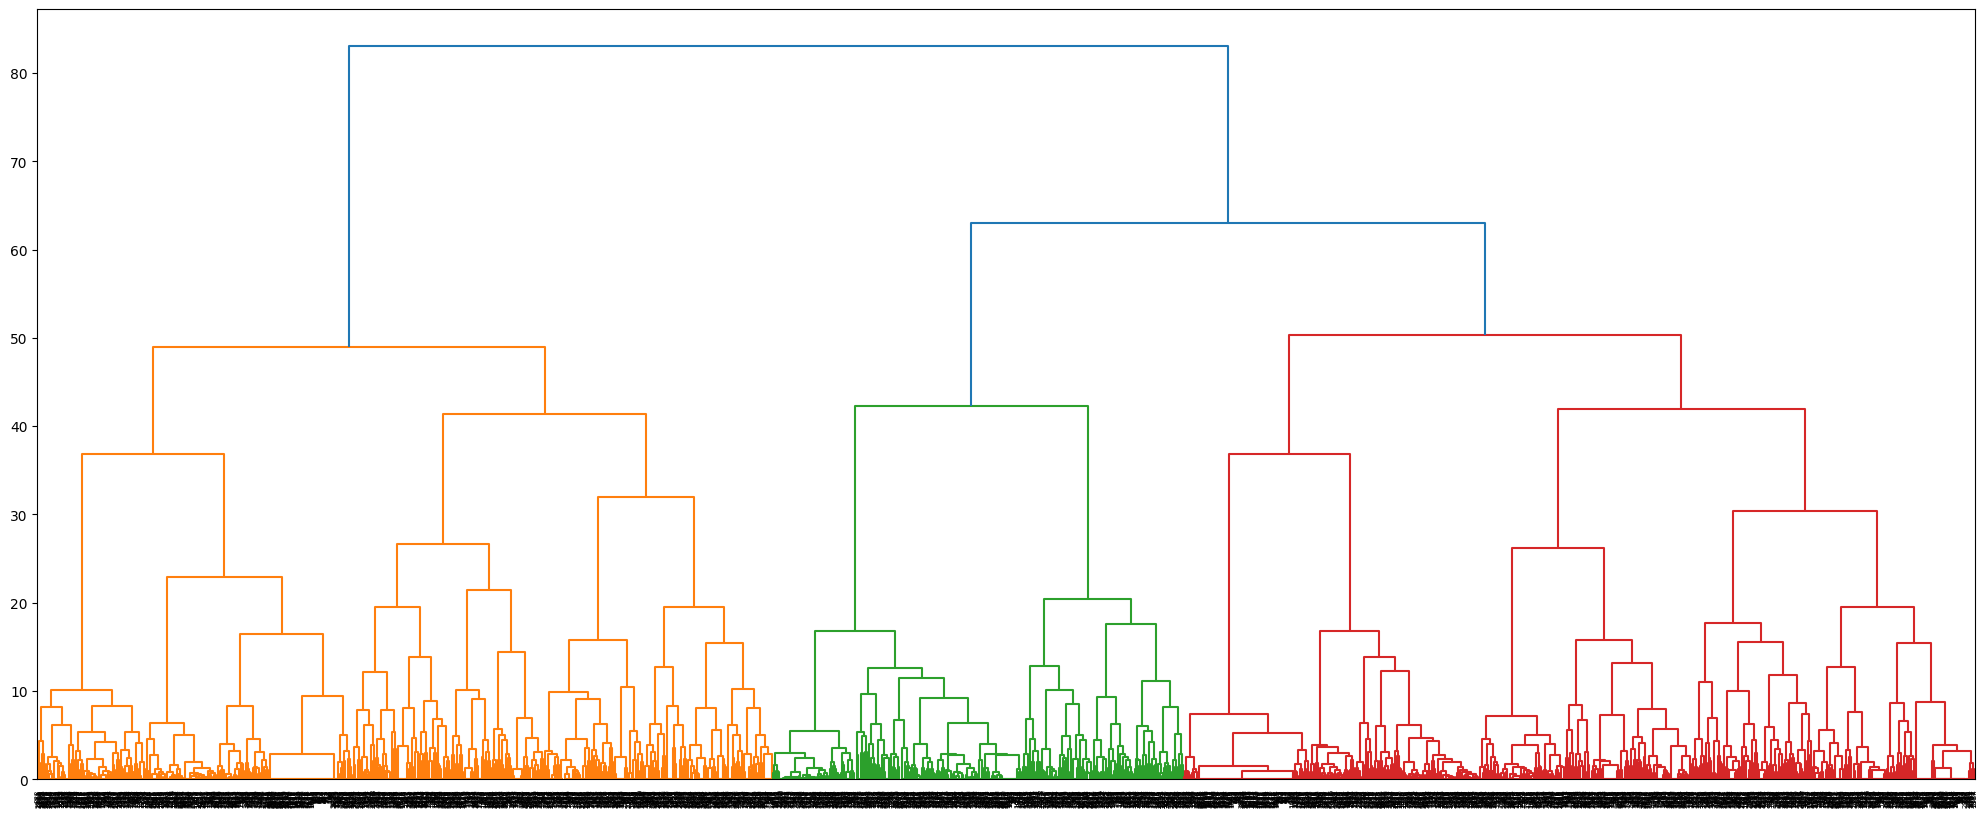

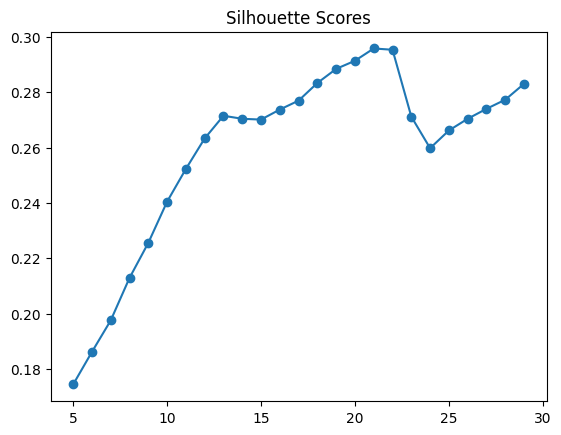

NMI: 0.39283098348271794


In [1285]:
linkage_data_ward = perform_hierarchical_clustering(cluster_embeddings, "ward")

In [1287]:
get_hierarchical_clusters(13, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 176
Sample Docs:=========
compressor lost power
batteries show no charge
differential lock broken
no excitation on hoist
alternator not charging
compressor found not working
replace inverter batteries with no charge
drag generator fault
hydraulic pump number bad leak
swing generator overvoltage

Top words:=========
batteries
not
charge
compressor
no

Top failure modes:=========
no charge
unserviceable
not working
fault
failed

Top equipment:=========
compressor
batteries
generator
pump
battery

Inherent functions in order:
generating (143)
storing (8)
covering (4)
driving (4)
controlling (3)
holding (3)
matterprocessing (2)
sensing (2)
protecting (2)
emitting (2)
restricting (1)
interfacing (1)
guiding (1)

Cluster 2 :
Cluster Size:========= 338
Sample Docs:=========
engine fan speed resistor is not working
windrow light not working
air conditioner compressor corroded
air conditioner fan unserviceable new
rear air conditioner unserviceable
air conditi

In [1288]:
get_hierarchical_clusters(21, linkage_data_ward)

Cluster 1 :
Cluster Size:========= 176
Sample Docs:=========
compressor needs replacement unserviceable
battery dropped cell
compressor not working
air conditioning fans unserviceable
drag generator fault
alternator fault
alternator unserviceable
generator is faulty
replace batteries with no charge
unserviceable compressor

Top words:=========
batteries
not
charge
compressor
no

Top failure modes:=========
no charge
unserviceable
not working
fault
failed

Top equipment:=========
compressor
batteries
generator
pump
battery

Inherent functions in order:
generating (143)
storing (8)
covering (4)
driving (4)
controlling (3)
holding (3)
matterprocessing (2)
sensing (2)
protecting (2)
emitting (2)
restricting (1)
interfacing (1)
guiding (1)

Cluster 2 :
Cluster Size:========= 116
Sample Docs:=========
engine bay light needs replacing
dash lights are on
lost lights inside circuit breaker
VIMS keypad backlight blown
dash backlight blown
vims keypad light needs clean out
rear lights not working